In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
from skimage.data import shepp_logan_phantom

In [2]:
#res in cm
res = 0.1
#fov in cm
fov_x = 5
fov_y = 5

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels = pixels_x*pixels_y
print(pixels_x)
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
echo_time = 5e-5

50


0.5405962334298786
0.0
0.2702981167149393


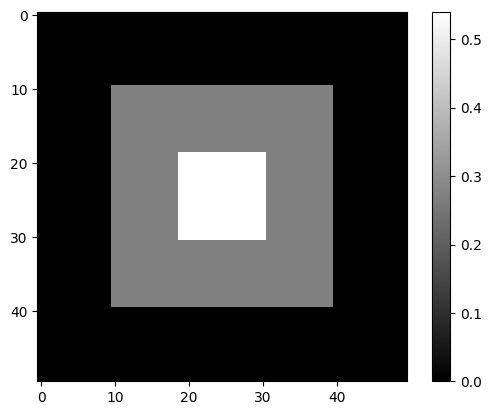

In [3]:
image = np.ones((pixels_x, pixels_y))

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

print(mxy_myelin)
print(mxy_wm)
print(mxy_mixed)

outer_square_size = int(1.0 * pixels_x) 
middle_square_size = int(0.6 * pixels_x)
inner_square_size = int(0.25 * pixels_x)  

# Calculate starting and ending indices for each square to center them
outer_start = (pixels_x - outer_square_size) // 2
outer_end = outer_start + outer_square_size

middle_start = (pixels_x - middle_square_size) // 2
middle_end = middle_start + middle_square_size

inner_start = (pixels_x - inner_square_size) // 2
inner_end = inner_start + inner_square_size

# Define the intensity values for each section
# Outermost square (100% WM - white, intensity = 1)
image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM

# Middle square (50/50 of WM and myelin - medium gray)
image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)

# Innermost square (100% myelin - black, intensity = 0)
image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)

# image = shepp_logan_phantom()
# pixels_x = 400
# pixels_y = 400

# Display the image using matplotlib
plt.imshow(image, cmap='gray', interpolation='nearest')
#plt.axis('off')  # Turn off axis
plt.colorbar()
plt.show()



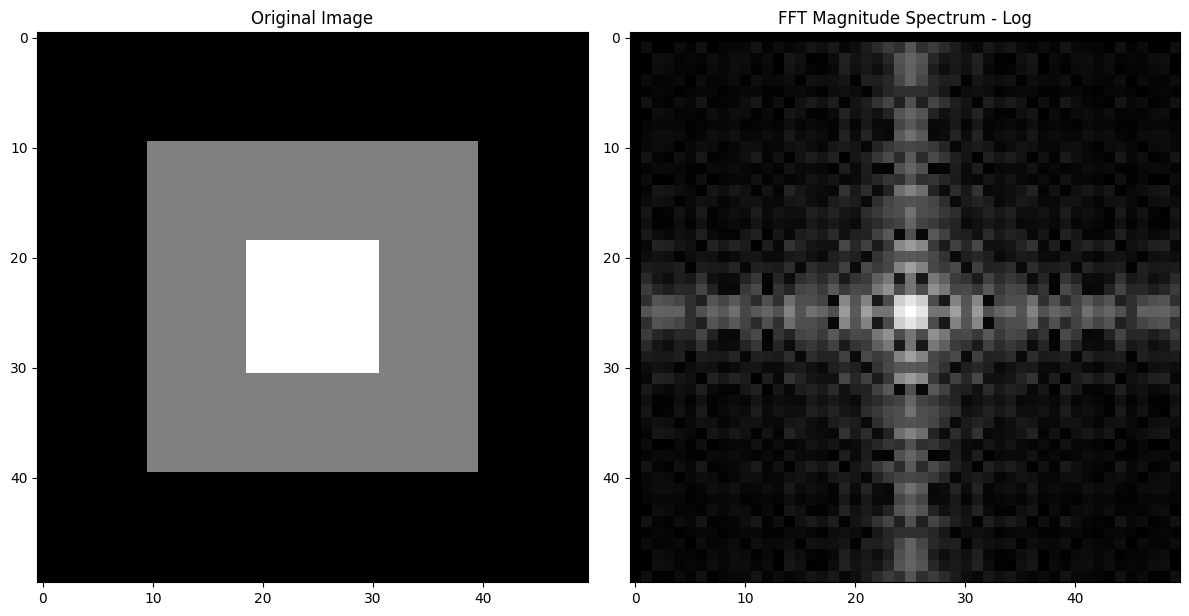

In [4]:
f_image = np.fft.fft2(image)

fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility

# Plot the original image and its FFT magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum - Log")
plt.imshow(magnitude_spectrum, cmap='gray')
#plt.axis('off')

plt.tight_layout()
plt.show()

0.5
157
(2, 3925)


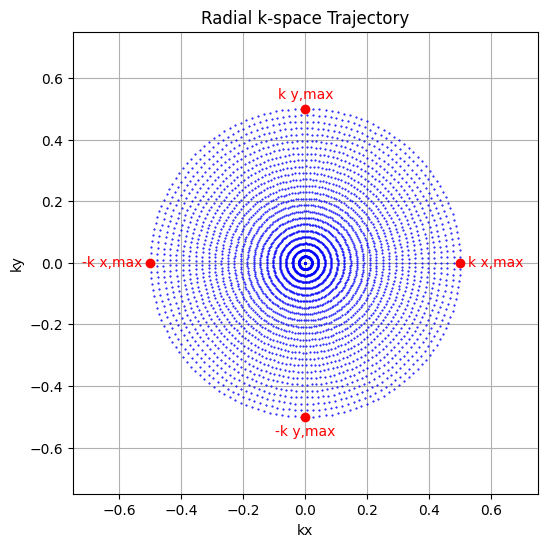

In [22]:
#res in mm
res_mm = 1
max_radii = 0.5/res_mm
print(max_radii)
nspokes = int(2*np.pi*max_radii*pixels_x) # Number of rays
#nspokes = 45
num_samples_per_ray = int(max_radii*pixels_x) # Number of samples per ray
print(nspokes)

# Initialize an empty k-space list to store sampled points
k_space = np.zeros((nspokes * num_samples_per_ray,), dtype=complex)

# Create radial k-space sampling points (rays)
angles = np.linspace(0, 2 * np.pi, nspokes, endpoint=False)  # Angle of the rays
radii = np.linspace(0, max_radii, num_samples_per_ray)  # Radial distance (from the center)
#print(radii)
#print(angles)

# Prepare spatial coordinates
x_coords = np.arange(pixels_x)
y_coords = np.arange(pixels_y)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)  # Create a grid of image coordinates

# Flatten the image for efficient computation
image_flattened = image.flatten()

# Loop over rays to calculate Fourier coefficients
index = 0
kx_values = []
ky_values = []
for angle in angles:
    for radius in radii:
        # Calculate the kx, ky coordinates for each sampled point
        kx = radius * np.cos(angle)  # x-component in frequency domain
        ky = radius * np.sin(angle)  # y-component in frequency domain

        # Store kx and ky for density compensation
        kx_values.append(kx)
        ky_values.append(ky)
        
        # Compute the Fourier coefficient for this (kx, ky)
        k_space[index] = np.sum(image_flattened * np.exp(-1j * 2 * np.pi * (kx * x_grid.flatten() / pixels_x + ky * y_grid.flatten() / pixels_y)))
        index += 1

# Convert kx_values and ky_values to numpy arrays
kx_values = np.array(kx_values)
ky_values = np.array(ky_values)

ktraj = np.stack((ky_values.flatten(), kx_values.flatten()), axis=0)
print(ktraj.shape)

# Visualize the radial k-space sampling points (this shows the rays)
plt.figure(figsize=(6, 6))
for angle in angles:
    x_vals = np.linspace(0, max_radii * np.cos(angle), num_samples_per_ray)
    y_vals = np.linspace(0, max_radii * np.sin(angle), num_samples_per_ray)
    plt.plot(x_vals, y_vals, 'b.', markersize=1)
plt.title('Radial k-space Trajectory')
plt.xlabel('kx')
plt.ylabel('ky')
plt.axis()
plt.grid(True)

# Adjust the axis limits to provide padding for text
padding = 0.5 * max_radii  # 10% of max_radii for padding
plt.xlim(-max_radii - padding, max_radii + padding)
plt.ylim(-max_radii - padding, max_radii + padding)

# Plot markers on the axes at kmax and -kmax
plt.plot([max_radii, -max_radii], [0, 0], 'ro', label='kx markers')  # Markers along x-axis
plt.plot([0, 0], [max_radii, -max_radii], 'ro', label='ky markers')  # Markers along y-axis

# Add text labels near the markers with offsets
text_offset = 0.05 * max_radii  # Offset for the text relative to the marker
plt.text(max_radii + text_offset, 0, 'k x,max', color='red', fontsize=10, ha='left', va='center')  # x-axis positive
plt.text(-max_radii - text_offset, 0, '-k x,max', color='red', fontsize=10, ha='right', va='center')  # x-axis negative
plt.text(0, max_radii + text_offset, 'k y,max', color='red', fontsize=10, ha='center', va='bottom')  # y-axis positive
plt.text(0, -max_radii - text_offset, '-k y,max', color='red', fontsize=10, ha='center', va='top')  # y-axis negative

plt.show()
#print(ktraj)


In [23]:
# Parameters
N_x = pixels_x  # Example value for the spatial dimension
N_k = nspokes*num_samples_per_ray

#print(k_space)

# Generate x- and y-coordinates with "isocentre" at the N_x/2+1 index
xidx, yidx = np.meshgrid(np.arange(-N_x/2, N_x/2), np.arange(-N_x/2, N_x/2))

# Loop over each k-location to construct the spatial phase modulation
F = np.zeros((N_k, N_x, N_x), dtype=complex)

for k_index in range(0, N_k- 1):
    kx = np.real(k_space[k_index])
    ky = np.imag(k_space[k_index])
    F[k_index, :, :] = np.exp(1j * 2 * np.pi * (kx * xidx + ky * yidx))

# Reshape F so that each row is a single k-space encoding
print(F.shape)
F = F.reshape(N_k, -1)
reshaped_image = image.reshape(-1)
#dot product
d = F @ reshaped_image
print(F.shape)
print(d.shape)



(3925, 50, 50)
(3925, 2500)
(3925,)


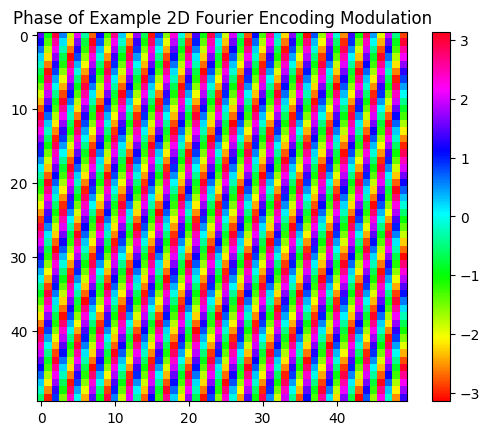

In [24]:
# Show an example encoding (using the 2000th row)
example_encoding = F[2, :]

# Reshape the encoding to a 2D array (N_x x N_x)
example_encoding_2d = np.reshape(example_encoding, (N_x, N_x))

# Plotting the phase of the 2D Fourier Encoding Modulation
plt.figure()
plt.imshow(np.angle(example_encoding_2d), cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title('Phase of Example 2D Fourier Encoding Modulation')
plt.colorbar()
plt.show()

Shape of F: (2500, 3925)
Shape of d: (3925,)
Shape of x_reconstructed: (2500,)
Shape of image_reconstructed: (50, 50)


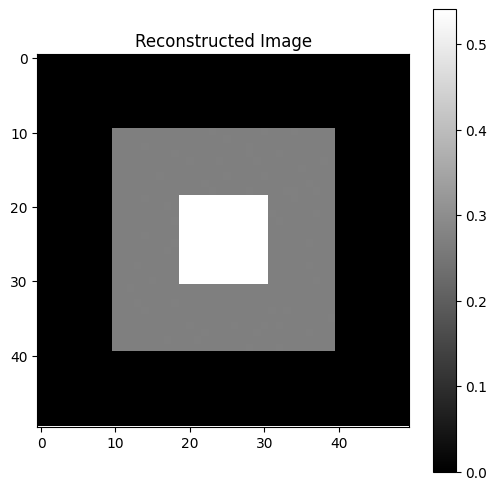

NRMSE (Direct Inverse): 0.0000


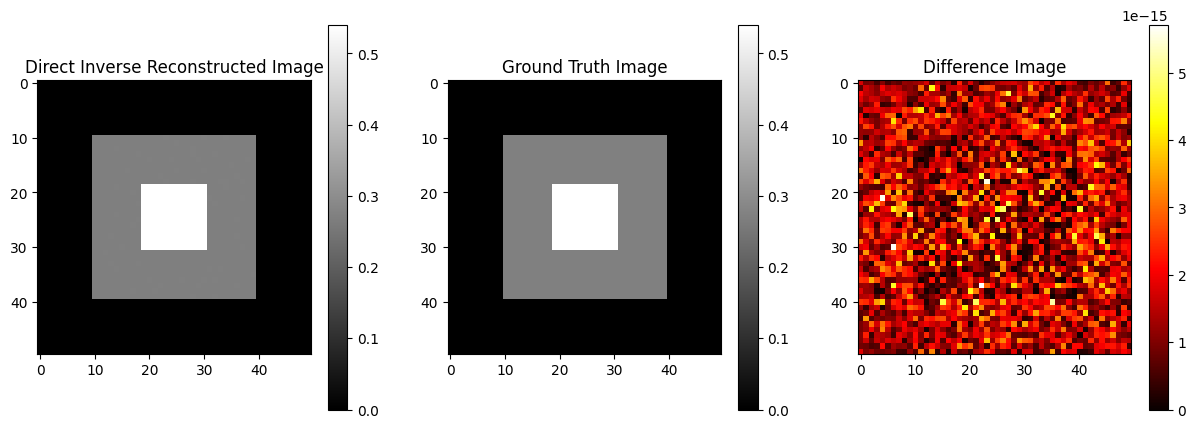

In [25]:
# Compute the naive inverse using NumPy (similar to F \ d in MATLAB)

# Reconstruction using pseudo-inverse
x_reconstructed = np.linalg.pinv(F) @ d  # Reconstruct the i-th image

print("Shape of F:", np.linalg.pinv(F).shape)  # Should be (N_x^2, N_k)
print("Shape of d:", d.shape)                 # Should be (N_k,)
print("Shape of x_reconstructed:", x_reconstructed.shape)  # Should be (N_x^2,)

#average_image = np.mean(x_reconstructed, axis=1) 

# Reshape the 1D vector to 2D
image_reconstructed = x_reconstructed.reshape(N_x, N_x)
#image_reconstructed = average_image.reshape(N_x, N_x)
print("Shape of image_reconstructed:", image_reconstructed.shape)  # Should be (N_x, N_x)
#print("Shape of image_reconstructed:", average_image.shape)  # Should be (N_x, N_x)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(image_reconstructed), cmap='gray')
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()

def compute_nrmse(est, ground_truth):
    """Compute the Normalized Root Mean Square Error (NRMSE)."""
    # Use the absolute values for complex images
    est_abs = np.abs(est)
    ground_truth_abs = np.abs(ground_truth)
    return np.sqrt(np.mean((est_abs - ground_truth_abs) ** 2)) / np.sqrt(np.mean(ground_truth_abs ** 2))

def display_results(est, ground_truth, N_x, title):
    """Display the reconstructed image, ground truth, and difference image."""
    est_image = np.abs(est).reshape(N_x, N_x)
    ground_truth_image = np.abs(ground_truth).reshape(N_x, N_x)
    diff_image = np.abs(est_image - ground_truth_image)

    plt.figure(figsize=(15, 5))

    # Reconstructed image
    plt.subplot(1, 3, 1)
    plt.imshow(est_image, cmap='gray')
    plt.colorbar()
    plt.title(f'{title} Reconstructed Image')

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.colorbar()
    plt.title('Ground Truth Image')

    # Difference image
    plt.subplot(1, 3, 3)
    plt.imshow(diff_image, cmap='hot')
    plt.colorbar()
    plt.title('Difference Image')

    plt.show()


# Flatten for comparison
true_image_flat = image.flatten()
reconstructed_image_flat = image_reconstructed.flatten()

# Compute NRMSE
nrmse_value = compute_nrmse(reconstructed_image_flat, true_image_flat)
print(f'NRMSE (Direct Inverse): {nrmse_value:.4f}')

# Display images
display_results(reconstructed_image_flat, true_image_flat, N_x, 'Direct Inverse')